In [9]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import qutip as quit
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve)
from qutip.measurement import measure_observable, measurement_statistics
from qutip.expect import expect
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
#Add util to the path
import sys
sys.path.append('../util')
sys.path.append('../')

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
#import savgol:
from scipy.signal import savgol_filter
from fitting_functions_ZNE import third_no_first_ZNE, order_poly_ZNE, order_poly_instance, converge_ZNE_order, converge_ZNE_loocv, pade_fit_ZNE

from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed
from functions_util import cetina_thermal_exp, cetina_envelope_exp,calibrate_sim_Omegas
from samplers_util import thermal_rejection
from tqdm import tqdm

In [10]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import qutip as quit
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve)
from qutip.measurement import measure_observable, measurement_statistics
from qutip.expect import expect
from scipy.optimize import curve_fit

#Add util to the path
import sys
sys.path.append('../util')
from samplers_util import thermal_rejection
from fitting_functions_ZNE import third_no_first_ZNE, converge_ZNE_loocv
import matplotlib as mpl


In [11]:
"""Figure includes Rabi oscillations for Gaussian noise, and regions for Rydberg and trapped ion error mechanisms. 
|---|--|
|   |  |
|-|-|--|
| | |  |
|-|-|--|
"""

columns = 2
rows = 2
scol=(3+3/8) #single column width of PRL,
dcol=2*scol # double column,
size_col = scol*columns#[scol, dcol][columns-1]
size_row = scol*rows#scol, dcol][rows-1]

fullwidth=6.3,
from matplotlib import cm
gr=(np.sqrt(5.0) - 1.0) / 2.0 #golden ratio,


mpl.rcParams.update({
    "ytick.direction": "in",
    "xtick.direction": "in",
    "axes.labelpad": 0,
    "font.size": 10,
    "legend.frameon": True,
    "figure.dpi":200,
    "figure.figsize": [size_col, size_row * gr],
    "font.family": "Helvetica",
    #"axes.prop_cycle": cycler('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
    # "axes.prop_cycle": cycler('color', palettable.colorbrewer.sequential.Reds_9.mpl_colors[1:])
})



#Create a matplotlib subplots in the layout above
fig = plt.figure(figsize=(12, 6))
#don't display the ax_c and ax_d plots
#Make the ticks on ax_bii on the  right instead of left:
#ax_bii.yaxis.tick_right()
#turn off the 

#ax_bii.set_ylabel('Population Transfer')
#Set the ax_bii y-axis equal to the ax_bi y-axis
#ax_bii.set_ylim(ax_bi.get_ylim())


fig.tight_layout()
#plt.show()


<Figure size 2400x1200 with 0 Axes>

In [12]:
#Reading in Or Data:
#Data files:
#Output data: 
#shape = heating, time, qubit
def exp_fit(t, A, B, C, D):
    return A*np.exp(-B*t)*np.cos(C*t+D) + A
def rabi_fit(t, Omega):
    return (1-np.cos(Omega*t))/2
KHz = 1e3
micro = 1e-6
Omega =  2210*KHz
sigma = .1*Omega #MODIFIED
delta_samples = 1000
dense_samples = 100000
nano = 1e-9
n_bar = 800
time_points = 100


t = np.linspace(0, 40*micro, time_points)
def Rabi(Omega_array, t_array):
    output = np.zeros((len(Omega_array), len(t_array)))
    for i, Omega in enumerate(Omega_array):
        output[i] = (1-np.cos(Omega*t_array/2))/2
    return output


NORMALIZER = 280/0.15

def sample_thermal_n(n_bar:int):
    n_max = 20*n_bar
    
    n_bar = int(n_bar*NORMALIZER)
    n_max = int(n_max*NORMALIZER)
    if n_bar == 0:
        return 0
    #print(n_bar, n_max)
    def pr_n(n: int, n_bar:int):
        """Returns the probability of sampling the value $n$ from the thermal distribution"""
        return (1/(1 + n_bar)) * np.power((n_bar/(1 + n_bar)),n)
        return (1 - n_bar) * n_bar**n
    pr_0 = pr_n(0, n_bar)
    
    n = np.random.randint(0, n_max)
    r = np.random.uniform(0, pr_0)
    pr_n_sample = pr_n(n, n_bar)
    while r > pr_n_sample:
        n = np.random.randint(0, n_max)
        r = np.random.uniform(0, pr_0)
        pr_n_sample = pr_n(n, n_bar)
    return n/NORMALIZER - n_bar/NORMALIZER

def sample_normal(theta:float):
    
    return np.random.normal(0, theta)
    #return n
    
#Plotting the first Omega:
Omega_test = 1648442
theta_alpha = -42409
Omega_test = 3750000
max_time = 10
times = np.linspace(0, max_time*micro, time_points)
#times = times*micro
n_bar = 0.04
delta_thermal = np.array([sample_normal(n_bar) for i in range(delta_samples)])
delta_thermal_dense = np.array([sample_normal(n_bar) for i in range(dense_samples)])

P_thermal = Rabi(Omega_test*(1+delta_thermal), times)
P_avg_thermal = np.mean(P_thermal, axis=0)

times_dense = times#np.linspace(0, *micro, time_points)
times_dense_plotting = np.linspace(0, max_time, time_points)
P_thermal_dense = Rabi(Omega_test*(1+delta_thermal), times_dense)
P_thermal_dense_dense = Rabi(Omega_test*(1+delta_thermal_dense), times_dense)

#print(P_thermal_dense.shape)
P_avg_thermal_dense = np.mean(P_thermal_dense, axis=0)
#print(P_avg_thermal_dense)

def gen_noisy_rabi(Omega, theta, delta_samples, target_time=None):
    if target_time is None:
        target_time = times_dense
    delta_thermal = np.array([sample_normal(theta) for i in range(delta_samples)])
    P_thermal = Rabi(Omega*(1+delta_thermal), target_time)
    #print(P_thermal.shape)
    P_avg_thermal = np.mean(P_thermal, axis=0)
    P_std_thermal = np.std(P_thermal, axis=0)/np.sqrt(delta_samples)
    return P_avg_thermal, P_std_thermal

In [13]:

ZNE_points = np.array([0, 1, 1.1, 1.3, 1.6, 2 ])#,2.5, 3, 3.5])

def create_linear_function(y_at_0_5):
    # Given points
    x1, y1 = 0.5, y_at_0_5
    x2, y2 = 1, 1
    
    # Calculate slope (a) and intercept (b)
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1
    
    # Return the linear function
    def linear_function(x):
        return a * x + b
    
    return linear_function

# Example usage:
linear_func = create_linear_function(0.3)

normalized_ZNE_points_for_color = linear_func(ZNE_points/max(ZNE_points))
#cm_subsection = np.linspace(0.2, 1.0, len(ZNE_points) )
Reds = [ cm.Reds(x) for x in normalized_ZNE_points_for_color ]
cmap = LinearSegmentedColormap.from_list('name', Reds[1:])
print(Reds)
baseline = n_bar  # MODIFIED
#get a blue to red colormap
colors = Reds#cmap(np.linspace(0, 1, len(ZNE_points)))

#print(colors)
# Add a color bar:
colorbar = plt.cm.ScalarMappable(cmap=cmap)
#colorbar.set_array(ZNE_points[1:] * baseline)

# Add color bar to ax_bii
test_labels = np.array([0.04, 0.05, 0.06, 0.07, 0.08])
labels = np.array(['{:.3f}'.format(ZNE_points[i]*baseline) for i in range(1,len(ZNE_points))])

normalized_ticks = normalized_ZNE_points_for_color[1:]
ticks_test = linear_func(np.array([0.04, 0.05, 0.06, 0.07, 0.08])/(max(ZNE_points)*baseline))
print('ticks')
print(normalized_ticks)
print(ticks_test)

#cbar.set_label(r'Standard Deviation, $\sigma$', labelpad=5)
#labels[0] = ''
#What's what?
"""
normalized_ZNE_points_for_color runs from 0.3 to 1, and is used both in cmap and in definding ticks
Removing if from ticks makes the points be uniformly spaced. 
Seeting the ticks to be a different set puts them in the correct place? NO, they are shifted incorrectly?
setting the label + the ticks:
-- No, not correct
Ok, forgetting linear func!

"""



# Set the tick positions and labels
#tick_positions = cm_subsection[1:]  # Assuming cm_subsection contains the tick positions
#tick_labels = ['0', '0.04', '0.045', '0.05', '0.055']#, '0.60']  # Ensure this list has the same length as tick_positions

#cbar.set_ticks(tick_positions)
#cbar.set_ticklabels(tick_labels)

#print(cm_subsection)


ZNE_data = np.zeros((len(times_dense), len(ZNE_points)))
ZNE_std = np.zeros((len(times_dense), len(ZNE_points)))
for i in range(len(ZNE_points)):
    color = colors[i]
    
    ZNE_data[:,i], ZNE_std[:,i] = gen_noisy_rabi(Omega_test, baseline*ZNE_points[i], delta_samples)

#Draw a vertial line at the 3rd peak:
peak_index = 84

#Plot the extrapolation:
for i in range(len(ZNE_points)):
    color = colors[i]
    if i == 0:
        color = 'k'
    #ax_bii.errorbar(ZNE_points*baseline, ZNE_data[peak_index,:], yerr=ZNE_std[peak_index,:], color=colors[:,0], fmt='o')  
#Fit to third_no_first



function = converge_ZNE_loocv(ZNE_points[1:]*baseline, ZNE_data[peak_index,1:], remove_first=True, return_order=False)
ZNE_points_dense = np.linspace(0, max(ZNE_points), 50)*baseline
dense_data     = np.zeros((len(times_dense_plotting), len(ZNE_points_dense)))
dense_data_std = np.zeros((len(times_dense_plotting), len(ZNE_points_dense)))
for i in tqdm(range(len(ZNE_points_dense))):
    dense_data[:,i], dense_data_std[:,i] = gen_noisy_rabi(Omega_test, ZNE_points_dense[i], delta_samples)
    
dense_dense_data     = np.zeros((len(ZNE_points_dense)))
dense_dense_data_std = np.zeros((len(ZNE_points_dense)))
    
ZNE_points_dense_dense = np.linspace(0, max(ZNE_points), 50)*baseline
for i in tqdm(range(len(ZNE_points_dense_dense))):
    dense_dense_data[i], dense_dense_data_std[i] = gen_noisy_rabi(Omega_test, ZNE_points_dense[i], dense_samples, target_time=np.array([times_dense[peak_index]]))
#ax_bii.plot(ZNE_points[1:]*baseline, ZNE_data[peak_index,1:], c='k', label='Data Points', ls='--')
print(dense_data.shape)
print(dense_data_std.shape)

#ax_bii.plot(ZNE_points_dense, dense_dense_data, color='k', ls='', zorder=-1, alpha=0.2)#, linewidths=0)

#ax_bii.plot(ZNE_points_dense, dense_data[peak_index, :], c='k',ls='--', label='Exact', zorder=100)
#ax_bii.plot(ZNE_points_dense, dense_data[peak_index, :], c='k',ls='--', label='Exact')
#ax_bii.text(0.1, 0.3, 'Add Error bars\n Add error vs. time?\n Fix spacings', transform=ax_bii.transAxes)
#Get the ZNE points
ZNEd_data = np.zeros((len(times_dense)))
ZNE_orders = np.zeros((len(times_dense)))
for i in range(len(times_dense)):
    data = ZNE_data[i,:]
    function, order = converge_ZNE_loocv(ZNE_points[1:]*baseline, data[1:], return_order=True)
    ZNEd_data[i] = function(0)
    ZNE_orders[i] = order
    
    try:
        #print(order, ZNE_orders[i-1])
        if i < 5:
            raise Exception('Escape')
        if np.abs(order - ZNE_orders[i-1]) > 1:
            ZNE_orders[i] = ZNE_orders[i-1]
            function = converge_ZNE_order(ZNE_points[1:]*baseline, data[1:], order=ZNE_orders[i-1])
            ZNEd_data[i] = function(0)
            #converge_ZNE_loocv(ZNE_points[1:]*baseline, data[1:], return_order=True, debug=True)
    except:
        pass
print(ZNE_orders)

#ax_bi.scatter(times_dense_plotting, ZNE_orders/max(ZNE_orders))#, c='k', ls='--', label='Extrapolated')


[(1.0, 0.9607843137254902, 0.9411764705882353, 1.0), (0.9882352941176471, 0.6715417147251057, 0.5605382545174933, 1.0), (0.9882352941176471, 0.5807458669742407, 0.45645520953479435, 1.0), (0.9806228373702421, 0.40123029603998467, 0.2809688581314879, 1.0), (0.8281891580161476, 0.1253364090734333, 0.12710495963091117, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]
ticks
[0.3  0.37 0.51 0.72 1.  ]
[0.3   0.475 0.65  0.825 1.   ]


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]


(100, 50)
(100, 50)
[1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 2. 2. 2. 2. 2. 1.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 3. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2.]


In [14]:
from fitting_functions_ZNE import pade_v2, converge_ZNE_loocv, pade_v3, shift_polynomial
print(ZNE_points[1:]*baseline)
print(data[1:])
#First, we need to get the ZNE functions for each time point:
ZNE_functions = np.zeros((len(times_dense)), dtype=object)
for i in range(len(times_dense)):
    data = ZNE_data[i,:]
    function =  converge_ZNE_loocv(ZNE_points[1:]*baseline, data[1:])#, return_order=False)
    ZNE_functions[i] = function

#Convert ZNE functions to Pade:
#ZNE_pade = np.zeros((len(times_dense)), dtype=object)
#for i in range(len(times_dense)):
#    print(ZNE_functions[i])
#    #coefs = 
#    ZNE_pade[i] = pade_v3(ZNE_functions[i], ZNE_points[1]*baseline, ZNE_points[-1]*baseline)


[0.04  0.044 0.052 0.064 0.08 ]
[0.12052977 0.14638493 0.17774867 0.25655891 0.34420039]


0.8260000000000001 + 1.52·x¹ + 1.7999999999999998·x² + 4.0·x³
       3        2
0.826 x + 1.52 x + 1.8 x + 4
 
1


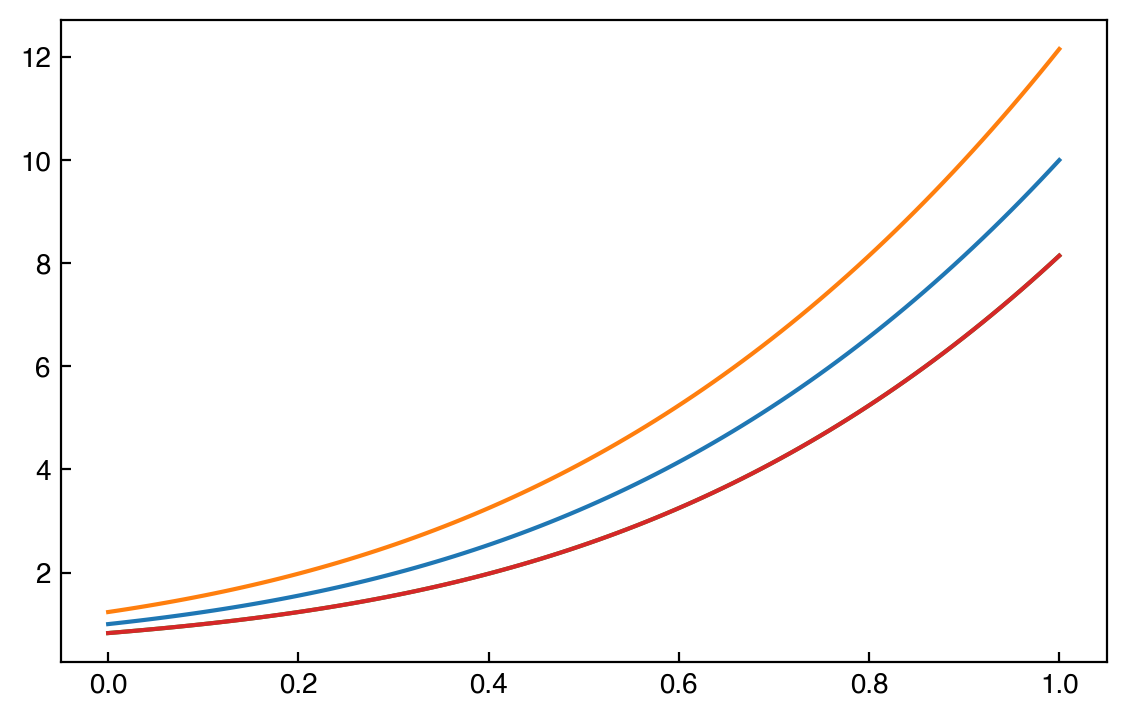

In [15]:
#Test shift:
poly_test = np.polynomial.Polynomial([1, 2, 3, 4])
plt.plot(np.linspace(0, 1, 100), poly_test(np.linspace(0, 1, 100)))
shifted = shift_polynomial(poly_test, 0.1)
plt.plot(np.linspace(0, 1, 100), shifted(np.linspace(0, 1, 100)))
shifted = shift_polynomial(poly_test, -0.1)
plt.plot(np.linspace(0, 1, 100), shifted(np.linspace(0, 1, 100)))
print(shifted)
#import pade:
from scipy.interpolate import pade
pade_version = pade(shifted.coef[::-1], 0, 3)
print(pade_version[0])
print(pade_version[1])

P = np.polynomial.Polynomial(pade_version[0])
Q = np.polynomial.Polynomial(pade_version[1])
plt.plot(np.linspace(0, 1, 100), P(np.linspace(0, 1, 100))/Q(np.linspace(0, 1, 100)))


0
2


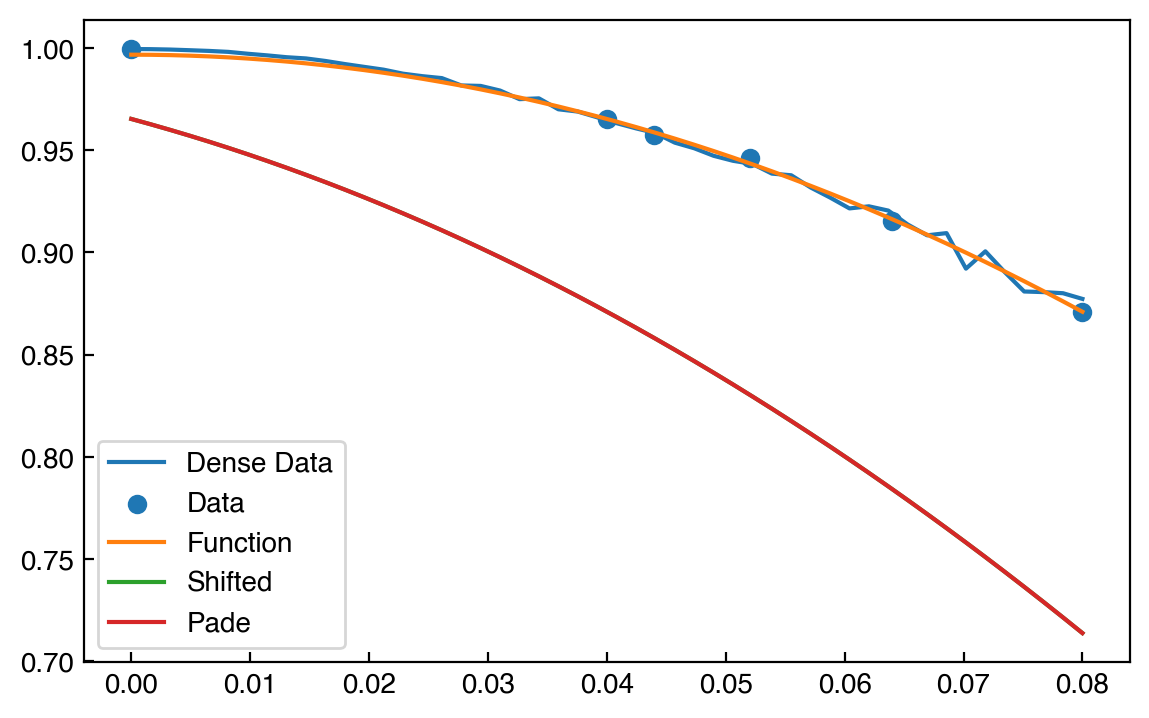

In [ ]:
sample_point = 50
#print(ZNE_pade[sample_point](0.05))
#plt.plot(ZNE_points_dense, ZNE_pade[sample_point](ZNE_points_dense), label='Pade')
plt.plot(ZNE_points_dense, dense_data[sample_point,:], label='Dense Data')
plt.scatter(ZNE_points*baseline, ZNE_data[sample_point,:], label='Data')
plt.plot(ZNE_points_dense, ZNE_functions[sample_point](ZNE_points_dense), label='Function')

poly  = ZNE_functions[sample_point]

x0 = ZNE_points[1]*baseline
xf = ZNE_points[-1]*baseline
shifted = shift_polynomial(poly, x0)
plt.plot(ZNE_points_dense, shifted(ZNE_points_dense), label='Shifted')
q = shifted.degree()#//2
p = 0#shifted.degree() - p
print(p)
print(q)
pade_version = pade(shifted.coef[::-1], p, q)
P = np.polynomial.Polynomial(pade_version[0])
Q = np.polynomial.Polynomial(pade_version[1])
plt.plot(ZNE_points_dense, P(ZNE_points_dense)/Q(ZNE_points_dense), label='Pade')


plt.legend()


In [17]:
# from scipy.interpolate import pade

# def pade_around_x0(coeffs, x0, m, l):
#     """
#     Perform a Padé approximation around x0.

#     Args:
#         coeffs: Coefficients of the Taylor series expansion around x0.
#         x0: The point around which to perform the approximation.
#         m: The order of the numerator polynomial.
#         n: The order of the denominator polynomial.
#     """

#     # Shift the coefficients to be around 0
#     shifted_coeffs = [coeffs[i] / np.math.factorial(i) * (x0 ** i) for i in range(len(coeffs))]

#     # Perform the Padé approximation around 0
#     p, q = pade(shifted_coeffs, m, l)

#     # Shift the Padé approximation back to x0
#     p_shifted = np.poly1d([p.coeffs[i] * (x0 ** i) for i in range(len(p.coeffs))])
#     q_shifted = np.poly1d([q.coeffs[i] * (x0 ** i) for i in range(len(q.coeffs))])

#     return p_shifted, q_shifted


In [18]:

# function = converge_ZNE_loocv(ZNE_points[1:]*baseline, ZNE_data[peak_index,1:], remove_first=True, use_pade=True, tail=0.5)
# print(function.coef)
# #function = order_poly_ZNE(ZNE_points[1:]*baseline, ZNE_data[peak_index,1:], order=5)
# p, q= pade_around_x0(function.coef, ZNE_points[1]*baseline, 3,1)
# plt.scatter(ZNE_points[1:]*baseline, ZNE_data[peak_index,1:], c='k')
# plt.ylim(0.4, 1.1)

# ZNE_more_dense = np.linspace(0, max(ZNE_points)*10, 100)*baseline
# plt.plot(ZNE_more_dense, function(ZNE_more_dense)+0.5, c='blue', label='Polynomial Fit')
# plt.plot(ZNE_more_dense, p(ZNE_more_dense)/q(ZNE_more_dense)+0.5, c='red', label='Pade Fit')


# # plt.plot(ZNE_points_dense, function(ZNE_points_dense), c='blue', label='Polynomial Fit')




In [19]:
ZNE_points[1:]*baseline

array([0.04 , 0.044, 0.052, 0.064, 0.08 ])

In [20]:
from numpy.polynomial.polynomial import Polynomial

def pade_fit_ZNE(x, y, tail=0, debug=False, dense_data = None):
    """Computes the pade fit for the data using P_l/Q_m for l = m for tail > 0, or m > l for tail = 0"""
    maximum_total_order = len(y) - 1
    #if tail == 0:
    residuals = np.ones((maximum_total_order, maximum_total_order)) * np.nan
    params_array = np.ones((maximum_total_order, maximum_total_order), dtype=object) 
    
    y = y - tail
    if debug:
        plt.scatter(x, y, s=110, zorder=-1, color='k')
        if dense_data is not None:
            plt.plot(dense_data[0], dense_data[1]-tail)
    for m in range(1, maximum_total_order):
        for l in range(1, m):
            if l + m > maximum_total_order:
                continue
            def cost_function(x)
            
        
            def pade_function(x, *params):
                P = Polynomial(params[:l+1])
                Q = Polynomial(params[l+1:])
                if Q(0) == 0:
                    return np.nan
                return P(x)/Q(x)
            try:
                #Fit to an order l polynomial first:
                poly_fit = Polynomial.fit(x, y, l)
                p0 = np.concatenate([poly_fit.coef, np.ones(m+1)])
                params, params_cov = curve_fit(pade_function, x, y, p0 = p0, maxfev=1000000)
                residuals[l, m] = np.sum((y - pade_function(x, *params))**2)
                params_array[l,m] = params
            except:
                counter = 0
                while counter < 100:
                    try:
                        counter += 1
                        #print(counter)
                        p0 = np.random.rand(m+l+2)*10
                        params, params_cov = curve_fit(pade_function, x, y, p0 = p0, maxfev=1000000)
                        residuals[l, m] = np.sum((y - pade_function(x, *params))**2)
                        params_array[l,m] = params
                        counter = 1000
                    except:
                        pass
                if counter < 900:
                    print('Failed for l,m = ' + str(l) + ', ' + str(m))
                    residuals[l, m] = np.inf
            if debug:
                plt.scatter(x, pade_function(x, *params))#, label=str(l) + ', ' + str(m))
                #try:
                #    #plt.scatter(dense_data[0], pade_function(dense_data[0], *params))
                #except:
                #    pass
    #Get the index of the smallest residual
    failed = True
    if debug:
        function = converge_ZNE_loocv(x, y, remove_first=True)
        plt.plot(dense_data[0], function(dense_data[0]), label='ZNE Loocv')
    while failed:
        min_residual = np.unravel_index(np.nanargmin(residuals), residuals.shape)
        if debug:
            print(residuals)
        l, m = min_residual
        print(l,m)
        #Check roots:
        #Find the zeros of the denominator. If there is a real zero betwen 0 and max(x), then discard the fit and try again:
        def find_denom_roots(l, current_params):
            Q = Polynomial(current_params[l+1:])
            return Q.roots()
        P = Polynomial(params_array[l,m][:l+1])
        #Check if there are any roots between 0 and max(x)
        print('Parameters to check:')
        print(params_array[l,m])
        roots = find_denom_roots(l, params_array[l,m])
        print(roots)
        print([P(root) for root in roots])  
        #print(roots)
        #Iterate through each root:
        failed = False
        if not failed:
            for root in roots:
                if np.abs(root.imag) <= 0.1 and root.real > 0 and root.real < max(x):
                    if np.abs(P(root)) < 1e-5:
                        failed = False
                    else:
                        failed = True
                    break
        if failed:
            residuals[min_residual] = np.inf
    
    
    
    
    def pade_function(x, *params, debug=False):
        P = Polynomial(params[:l+1])
        Q = Polynomial(params[l+1:])
        if debug:
            print(P)
            print(Q)
        if Q(0) == 0:
            return np.inf
        return P(x)/Q(x)
    params, params_cov = curve_fit(pade_function, x, y, p0 = [1 for _ in range(m+l+2)])
    if debug:
        plt.scatter(x, pade_function(x, *params), label=str(l) + ', ' + str(m))
        #if dense_data is not None:
        plt.plot(dense_data[0], pade_function(dense_data[0], *params), label=str(l) + ', ' + str(m))
        #Also plot the ZNE Loocv fit:
        
        plt.legend()
        
    return pade_function(0 ,*params, debug=True) + tail

SyntaxError: expected ':' (3167511376.py, line 19)

In [ ]:
peak_index = 35
print(ZNE_points)
pade_fit_ZNE(ZNE_points[1:]*baseline, ZNE_data[peak_index,1:], debug=True, tail=0.5, dense_data=[ZNE_points_dense, dense_data[peak_index, :]])

NameError: name 'ZNE_points' is not defined

In [ ]:
def fit_pade(x, y, m, n):
    # Define the Padé approximant function with fixed m and n
    def pade_approximant(x, *coeffs):
        num_coeffs = coeffs[:m+1]
        den_coeffs = coeffs[m+1:]
        
        numerator = sum([num_coeffs[i] * x**i for i in range(m+1)])
        denominator = 1 + sum([den_coeffs[j] * x**(j+1) for j in range(n)])
        return numerator / denominator

    # Initial guess for coefficients
    initial_coeffs = np.ones(m + n + 1)
    
    # Fit the Padé approximant to the data
    popt, pcov = curve_fit(pade_approximant, x, y, p0=initial_coeffs)
    return popt

# Function to evaluate the Padé approximant at x=0
def evaluate_at_zero(popt, m, n):
    num_coeffs = popt[:m+1]
    numerator = num_coeffs[0]  # Coefficient of x^0 term
    denominator = 1  # All terms in the denominator involve x^1 or higher
    return numerator / denominator

def pade_approximant(x, n_coeff, m_coeff):
    numerator = sum([n_coeff[i] * x**i for i in range(len(n_coeff))])
    denominator = 1 + sum([m_coeff[j] * x**(j+1) for j in range(len(m_coeff))])
    return numerator / denominator

# Optimize the degrees m and n to minimize the fitting error
def optimize_pade_degree(x, y, max_order=5):
    best_m, best_n = 1, 1
    best_error = np.inf
    best_popt = None

    for m in range(1, max_order + 1):
        for n in range(1, max_order + 1):
            try:
                popt = fit_pade(x, y, m, n)
                # Define the pade_approximant with fixed m and n for prediction
                def pade_approximant_fixed(x):
                    num_coeffs = popt[:m+1]
                    den_coeffs = popt[m+1:]
                    
                    numerator = sum([num_coeffs[i] * x**i for i in range(m+1)])
                    denominator = 1 + sum([den_coeffs[j] * x**(j+1) for j in range(n)])
                    return numerator / denominator

                y_fit = pade_approximant_fixed(x)
                error = np.linalg.norm(y - y_fit)
                if error < best_error:
                    best_error = error
                    best_m, best_n = m, n
                    best_popt = popt
            except Exception as e:
                # Skip fits that fail
                continue

    return best_m, best_n, best_popt, best_error


1 3
[ 3.84797158e-02 -1.92257051e-01 -2.80336541e+01  2.73879710e+02
 -7.95347760e+02]
[-1.92257051e-01 -2.80336541e+01  2.73879710e+02 -7.95347760e+02]
3
[0.03847972]
1


/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


NameError: name 'ZNE_more_dense' is not defined

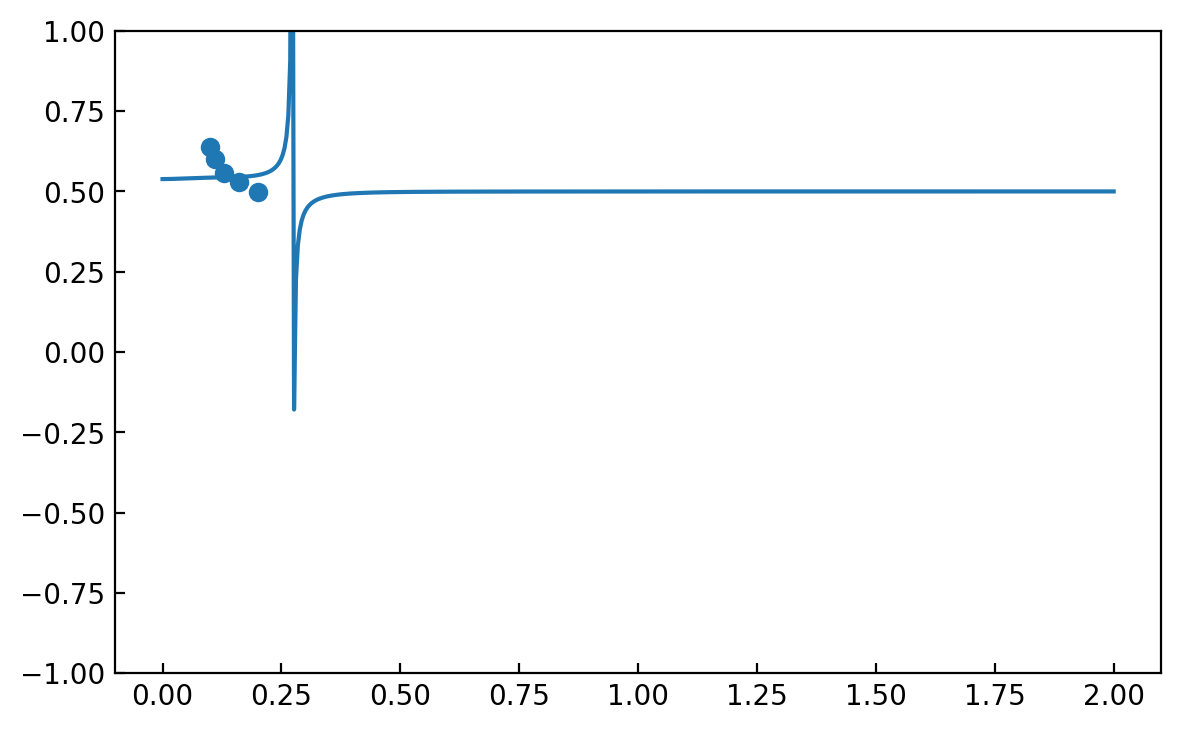

In [ ]:

x = ZNE_points[1:]*baseline
y = ZNE_data[peak_index,1:]-0.5
plt.scatter(x, y+0.5)
max_order = 6
best_m, best_n, best_popt, best_error = optimize_pade_degree(x, y, max_order)
print(best_m, best_n)
print(best_popt)
x_fit = np.linspace(0, max(x)*10, 500)
m_coeff = best_popt[:best_m]
n_coeff = best_popt[best_m:]

#n_coeff = best_popt[:best_n+1]
print(n_coeff)
print(best_n)
#m_coeff = best_popt[best_n+1:]
print(m_coeff)
print(best_m)
y_fit = pade_approximant(x_fit, m_coeff, n_coeff) +0.5
plt.ylim(-1, 1)
plt.plot(x_fit, y_fit, label=f'Padé approximant (m={best_m}, n={best_n})')
plt.plot(ZNE_more_dense, function(ZNE_more_dense)+0.5, c='blue', label='Polynomial Fit')
plt.plot(ZNE_points_dense, dense_data[peak_index, :], c='k',ls='--', label='Exact')


#plt.plot(ZNE_more_dense, function(ZNE_more_dense)+0.5, c='blue', label='Polynomial Fit')
#plt.plot(ZNE_more_dense, p(ZNE_more_dense)/q(ZNE_more_dense)+0.5, c='red', label='Pade Fit')


# plt.plot(ZNE_points_dense, function(ZNE_points_dense), c='blue', label='Polynomial Fit')


